# Database manipulation with polars

You can use any database library to manipulate data in the ARIEL database. In this example we will be using polars.

In [1]:
# Import the libraries
import polars as pl
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

## 1. How to get data about the experiment

As explained above, ARIEL stores every individual that existed during evolution in an SQL database. This includes individuals that died early as well as those that survived until the end. By querying this database, we can recreate population data and extract statistics about the evolutionary process.

### 1.1 Loading the database into a Polars DataFrame

All data about individuals is stored in the table individual.
Below is how to load this table into a Polars DataFrame.

In [2]:
# Load database table into Polars
file_path = "__data__/run_0033"

conn = sqlite3.connect(f"{file_path}/database.db")

data = pl.DataFrame(
    conn.execute("SELECT * FROM individual").fetchall(),
    schema=[col[1] for col in conn.execute("PRAGMA table_info(individual)")]
)

data.head()
data.tail()

/tmp/ipykernel_332580/127487873.py:6: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  data = pl.DataFrame(


id,alive,time_of_birth,time_of_death,requires_eval,fitness_,requires_init,genotype_,tags_
i64,i64,i64,i64,i64,f64,i64,str,str
526,0,10,10,0,0.000011,0,"""[[1676.5090338973798, -5921.92…","""{""ctk_string"": ""C<t(B2[l(B1[l(…"
527,0,10,10,0,0.000041,0,"""[[2495.8952622520096, 6260.599…","""{""ctk_string"": ""C[f(B[b(B1[t(B…"
528,0,10,10,0,0.000032,0,"""[[-2693.097793008781, -6683.62…","""{""ctk_string"": ""C[l(B[b(B2H4H6…"
529,0,10,10,0,0.000176,0,"""[[4292.1247550206535, -3290.76…","""{""ctk_string"": ""C[f(B7[l(B6[r(…"
530,0,10,10,0,0.000128,0,"""[[729.0967707303153, 1396.4528…","""{""ctk_string"": ""C[f(B7[t(B7[t(…"


### 1.2 Reconstructing the population per generation

ARIEL does not store a list of individuals per generation. Instead, each individual records:
- time_of_birth: the generation it was created
- time_of_death: the generation it disappeared

We reconstruct the population for every generation using this information.

In [3]:
# Determine generation range
min_gen = int(data["time_of_birth"].min())
max_gen = int(data["time_of_death"].max())

# Collect individuals alive per generation
population_per_gen = {
    gen: data.filter(
        (pl.col("time_of_birth") <= gen) & (pl.col("time_of_death") >= gen) )["id"].to_list() # TODO message john bug fix
    for gen in range(min_gen, max_gen + 1)
    }

# Structure data as a Polars dataframe
pop_df = pl.DataFrame({
    "generation": list(population_per_gen.keys()),
    "individuals": list(population_per_gen.values()),
    "pop size": [len(v) for v in population_per_gen.values()]
    })

pop_df.head()
# pop_df.tail()


generation,individuals,pop size
i64,list[i64],i64
0,"[1, 2, … 50]",50
1,"[1, 2, … 98]",98
2,"[1, 2, … 146]",98
3,"[1, 4, … 194]",98
4,"[5, 9, … 242]",98


In [4]:
# last_gen = data["time_of_birth"].max()       
# last_gen_df = data.filter(pl.col("time_of_birth") == last_gen).select(["id", "fitness_", "tags_"])
# print(f"Last generation: {last_gen}")                                                                                                             
# print(f"Population size: {len(last_gen_df)}")                                                                                                      

## 2. Computing fitness statistics per generation

Now that we know which individuals were alive in each generation, we can compute:
- Mean fitness
- Standard deviation
- Best (minimum) fitness

In [5]:
# Extract fitness values indexed by individual id
fitness_by_id = data.select(["id", "fitness_"])

means, stds, bests = [], [], []

for gen in pop_df["generation"]:
    ids = population_per_gen.get(gen, [])
    if not ids:
        means.append(np.nan)
        stds.append(np.nan)
        bests.append(np.nan)
        continue

    fits = (
        fitness_by_id
        .filter(pl.col("id").is_in(ids))
        .select(pl.col("fitness_").cast(pl.Float64))
        .to_series()
        .to_numpy()
    )

    if fits.size == 0:
        means.append(np.nan)
        stds.append(np.nan)
        bests.append(np.nan)
    else:
        means.append(float(np.mean(fits)))
        stds.append(float(np.std(fits)))
        bests.append(float(np.max(fits)))

# Add the statistics to the dataframe
pop_df = pop_df.with_columns([
    pl.Series("fitness_mean", means),
    pl.Series("fitness_std", stds),
    pl.Series("fitness_best", bests)
])

pop_df.tail()


generation,individuals,pop size,fitness_mean,fitness_std,fitness_best
i64,list[i64],i64,f64,f64,f64
6,"[9, 12, … 338]",98,0.001655,0.002037,0.011398
7,"[9, 12, … 386]",98,0.002147,0.002596,0.012652
8,"[9, 12, … 434]",98,0.002287,0.002727,0.012652
9,"[9, 12, … 482]",98,0.002631,0.002849,0.012652
10,"[9, 23, … 530]",98,0.002751,0.002843,0.012652


## 3. Plotting the fitness progression

With the computed statistics, we can visualize how fitness changes over generations.

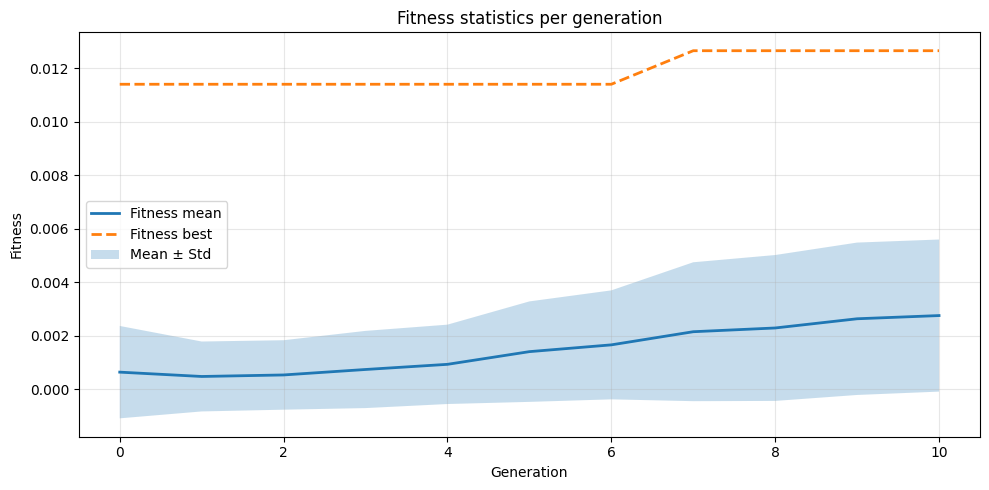

In [6]:
df = pop_df.drop_nulls(subset=["fitness_mean"])

x = df["generation"]
mean = df["fitness_mean"]
std = df["fitness_std"]
best = df["fitness_best"]

plt.figure(figsize=(10, 5))
plt.plot(x, mean, label="Fitness mean", linewidth=2)
plt.plot(x, best, "--", label="Fitness best", linewidth=2)
plt.fill_between(x, mean - std, mean + std, alpha=0.25, label="Mean ± Std")

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness statistics per generation")
plt.legend()
# plt.yticks(range(0, int(max(df["fitness_mean"])), 2))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [7]:
import json
ctk_strings = [json.loads(t).get('ctk_string') for t in data['tags_'][-50:]]
print(ctk_strings)

['C[f(H4B7[l(B3[b(B6[b(B3B)]H2)]B6[l(B2)]H5H5)]H6H1H4)]', 'C[f(H6H5H4B7[l(B3[l(B5[l(B)])b(B7[l(B3H2)]H1)]B5[l(B2)])])]', 'C[f(H6H5B2H4)]<b(B5B7[t(B3)r(B6[b(B3B3[r(B)]H2)])]H1H6)>', 'C[f(H)]<t(B1[l(B1[r(B6[t(B2)l(B5H6H3)])]H4H4)]H5)>', 'C[f(H4)]<b(B2[l(B3[l(B4H5)]H2)b(B6[r(B6)t(B6H7)]H4)]B7H7)>', 'C[l(B6[l(B2H5)b(B2[b(B3[b(B4)]H5H4H5B7)])t(B6[t(B1H4H1H1)]B6)])]', 'C[f(H4H5)]<b(BB7[l(B7H)]B6[r(B5[r(B6)]H7H7H2)])>', 'C[f(H5)]<b(B5[b(B3[t(B7[b(B2H5)l(B3[b(B6[t(B3)l(B6)])])]H4H1)]H1)])>', 'C[f(H3)]<b(B2[r(B[t(B2[t(BB)]H1)r(B3[b(B5[l(B3H5H6)]H4)])])])>', 'C[l(B7[l(B6[l(B7H)])b(B6[t(B2H5H4)])]H4)f(H2)]', 'C[f(H6H5B[l(B5[b(B6[l(B1)]B1H2H6H2)]B1H6)]H4BH5)]', 'C<b(B5[r(B2[r(B2[r(B[t(B2H5)r(B6)])])]BH2H4)]B7)>', 'C[f(B6[r(B2)])l(B6[t(BH2B5H3H5H5)]H2H4H4)]', 'C[f(B7[r(B2[r(B1[b(B5)])l(B1[t(BH2)]H7H4)t(B6)])]H4)]<b(B)>', 'C[f(H6H5)]<t(B7[l(B3[t(B2H2)r(B6BH5H)])]H4)>', 'C[r(B3[l(B6)]B3H5)f(H6)]<b(B2H4B6H5B7)t(BH1H2)>', 'C[f(B[b(B6B[l(B6[b(B1H4H4)]H7)b(B[l(B3H2)])]H4)]H4)]', 'C[f(H4H5H5)]<b(B[r(B7[t(

In [8]:
import canonical_toolkit as ctk

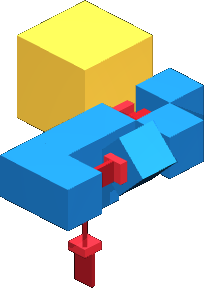

In [9]:
ctk.quick_view(ctk.node_from_string('C[f(H6B2[r(B7H5B[l(B4[r(B6BH4B)])])])]<b(B5B7H5H7)>').to_graph())

In [ ]:
# raise UserWarning

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 raise UserWarning                                                                            │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
UserWarning

In [11]:
ctk.snapshot_saver([ctk.node_from_string(ctk_string).to_graph() for ctk_string in ctk_strings], save_folder=f"{file_path}/snapshots")

Output()

Saved 50/50 snapshots to __data__/run_0033/snapshots

Output()

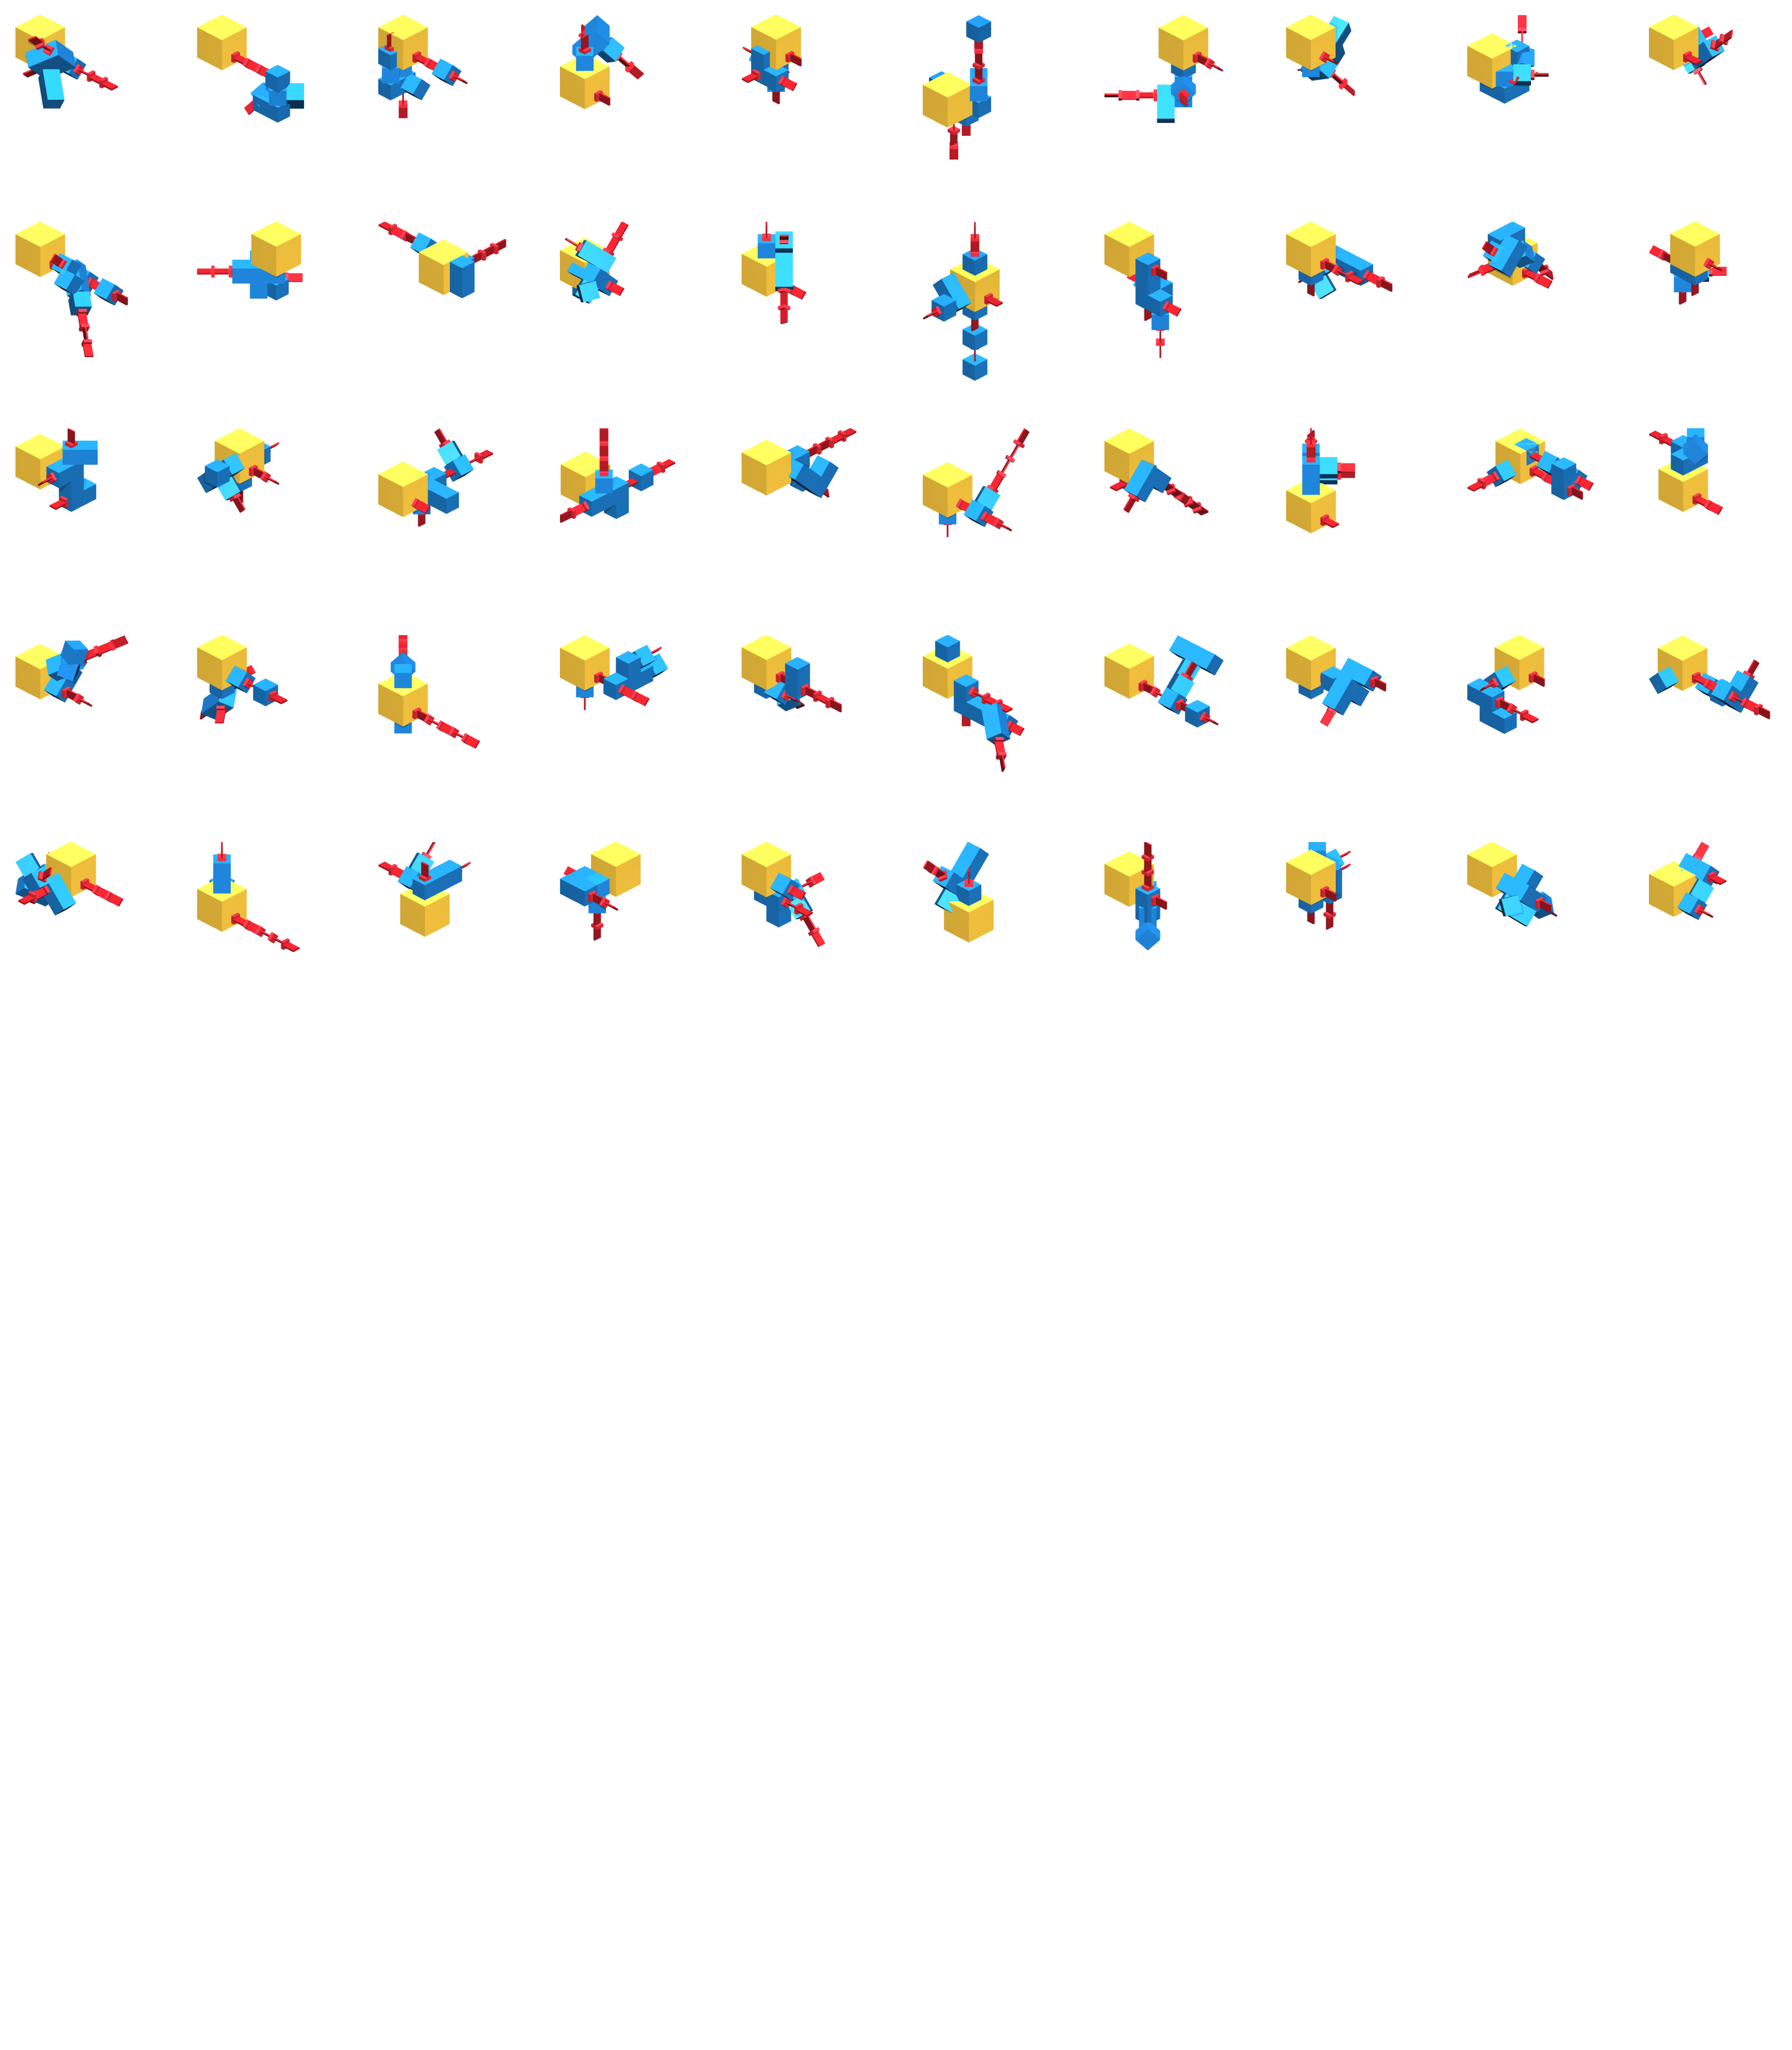

In [12]:
from canonical_toolkit.morphology.visual.plots import SnapshotGridPlotter

plotter = SnapshotGridPlotter.from_snapshot_folder(f"{file_path}/snapshots", grid_shape=(10, 10), snapshots_per_subplot=1)
plotter.plot()


In [13]:
last_gen = data["time_of_death"].max()                                                                                                            
                                                                                                                                                    
# Survivors are those whose death time equals the final generation                                                                                
# AND they weren't just born to die immediately                                                                                                   
survivors = data.filter(                                                                                                                          
    (pl.col("time_of_death") == last_gen) &                                                                                                       
    (pl.col("time_of_birth") < last_gen)  # survived at least one generation                                                                      
).select(["id", "fitness_", "time_of_birth", "time_of_death"])                                                                                    
                                                                                                                                                
print(f"Survivor count: {len(survivors)}")                                                                                                                                                                                                                                                 
                                                                                                                                                
                                                                                                                                                
last_gen = data["time_of_death"].max()                                                                                                            
                                                                                                                                                
# Break down by birth time                                                                                                                        
breakdown = data.filter(                                                                                                                          
    pl.col("time_of_death") >= last_gen                                                                                                           
).group_by("time_of_birth").agg(pl.count())                                                                                                       
                                                                                                                                                
print(breakdown.sort("time_of_birth"))


Survivor count: 50
shape: (10, 2)
┌───────────────┬───────┐
│ time_of_birth ┆ count │
│ ---           ┆ ---   │
│ i64           ┆ u32   │
╞═══════════════╪═══════╡
│ 0             ┆ 4     │
│ 1             ┆ 1     │
│ 3             ┆ 2     │
│ 4             ┆ 4     │
│ 5             ┆ 11    │
│ 6             ┆ 6     │
│ 7             ┆ 7     │
│ 8             ┆ 4     │
│ 9             ┆ 11    │
│ 10            ┆ 48    │
└───────────────┴───────┘


/tmp/ipykernel_332580/443326619.py:18: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  ).group_by("time_of_birth").agg(pl.count())


In [14]:
survivors = data.filter(                                                                                                                          
    (pl.col("time_of_death") == last_gen) &                                                                                                       
    (pl.col("time_of_birth") < last_gen)                                                                                                          
)                                                                                                                                                 
                                                                                                                                                
print(f"Fitness stats of survivors:")                                                                                                             
print(f"  Mean: {survivors['fitness_'].mean()}")                                                                                                  
print(f"  Std:  {survivors['fitness_'].std()}")                                                                                                   
print(f"  Max:  {survivors['fitness_'].max()}")                                                                                                   
print(f"  Min:  {survivors['fitness_'].min()}")                                                                                                   
                                                                                                                                                
# Full dataframe                                                                                                                                  
survivors.select(["id", "fitness_", "time_of_birth"])  

Fitness stats of survivors:
  Mean: 0.004638259717018184
  Std:  0.0027242639978301824
  Max:  0.012652072930440555
  Min:  0.001926184561414209


id,fitness_,time_of_birth
i64,f64,i64
9,0.002354,0
23,0.011398,0
26,0.002555,0
34,0.004243,0
97,0.003152,1
…,…,…
470,0.003443,9
473,0.007056,9
474,0.003863,9


In [15]:
gen_stats = []                                                                                                                                    
max_gen = int(data["time_of_death"].max())                                                                                                        
                                                                                                                                                
for gen in range(0, max_gen + 1):                                                                                                                 
    # Individuals alive DURING this generation (born <= gen, died > gen)                                                                          
    alive_during = data.filter(                                                                                                                   
        (pl.col("time_of_birth") <= gen) & (pl.col("time_of_death") > gen)                                                                        
    )                                                                                                                                             
                                                                                                                                                
    # Individuals born this generation                                                                                                            
    born_this_gen = data.filter(pl.col("time_of_birth") == gen)                                                                                   
                                                                                                                                                
    # Individuals that died this generation                                                                                                       
    died_this_gen = data.filter(pl.col("time_of_death") == gen)                                                                                   
                                                                                                                                                
    gen_stats.append({                                                                                                                            
        "generation": gen,                                                                                                                        
        "alive_during": len(alive_during),                                                                                                        
        "born": len(born_this_gen),                                                                                                               
        "died": len(died_this_gen),                                                                                                               
    })                                                                                                                                            
                                                                                                                                                
gen_df = pl.DataFrame(gen_stats)                                                                                                                  
gen_df                  

generation,alive_during,born,died
i64,i64,i64,i64
0,50,50,0
1,50,48,48
2,50,48,48
3,50,48,48
4,50,48,48
…,…,…,…
6,50,48,48
7,50,48,48
8,50,48,48


In [16]:
import json                                                                                                                                       
                                                                                                                                                    
# Get top X fittest individuals (sorted by fitness descending)                                                                                    
top_x = 10  # change this to your desired number                                                                                                  
                                                                                                                                                
top_individuals = data.sort("fitness_", descending=True).head(top_x)                                                                              
                                                                                                                                                
# Extract CTK strings                                                                                                                             
for row in top_individuals.iter_rows(named=True):                                                                                                 
    ctk_string = json.loads(row['tags_']).get('ctk_string')                                                                                       
    print(f"ID: {row['id']}, Fitness: {row['fitness_']:.6f}, CTK: {ctk_string}")                                                                  
                                                                                                                                                
                                                                                                                                                
top_x = 10                                                                                                                                        
top_ctk_strings = [                                                                                                                               
    json.loads(t).get('ctk_string')                                                                                                               
    for t in data.sort("fitness_", descending=True).head(top_x)['tags_']                                                                          
]                                                                                                                                                 
print(top_ctk_strings)

ID: 357, Fitness: 0.012652, CTK: C[f(H6H5B7H6B3[b(B6[b(B3B2[l(B1)]H4H6)])r(BH5)]H2)]
ID: 345, Fitness: 0.011413, CTK: C[f(H4H5)]<t(B2[r(B1)t(B6[r(B3H5)b(B3[r(B6[r(B7H1H6H4)])]B6)])])>
ID: 23, Fitness: 0.011398, CTK: C[f(HB1[r(B6[b(B3H5H6)]H3)]H5H6B4H)]
ID: 447, Fitness: 0.010099, CTK: C[f(H6H5B7[b(B3[l(B2[l(B2H2)])])t(B6[b(B2)])]HH5)]
ID: 288, Fitness: 0.008993, CTK: C[f(H6H5H4H6B3[b(B6[r(B2[r(B2H4)])])l(B6[t(B)])]B[r(B5)])]
ID: 427, Fitness: 0.008952, CTK: C[l(B[b(B3)t(B[b(B3[b(B1[l(B2[r(B2)])])])]H5)]B4H5H5H5)f(H6H5)]
ID: 342, Fitness: 0.007889, CTK: C[f(B7H3H1H4B2)]<t(B[r(B1H6H4)]H2H4H6H3)>
ID: 315, Fitness: 0.007711, CTK: C[f(H4H5)]<b(B7[l(B2[b(B3[t(B3)]B2[r(B2[r(B3)])]H7)])]H7)>
ID: 473, Fitness: 0.007056, CTK: C[f(H4H5H4HH2)]<b(B5[r(B6[b(B6)]B[rl(B2)])])>
ID: 166, Fitness: 0.006945, CTK: C[f(H4)]<b(B3[b(B1H)r(B2H6H2)]B7[t(B6[l(BH)]H4)])>
['C[f(H6H5B7H6B3[b(B6[b(B3B2[l(B1)]H4H6)])r(BH5)]H2)]', 'C[f(H4H5)]<t(B2[r(B1)t(B6[r(B3H5)b(B3[r(B6[r(B7H1H6H4)])]B6)])])>', 'C[f(HB1[r(B6[b(B3H